### Test where we compute cross correlations of DAS data in an attemopt to recover an EGF across some subset of channels

Note that in Dou et al. (2017), they conly cross correlate 1 minute DAS timseries that are known to contain vehicle noise. This explains why their stacked cross correlation images look so much cleaner than what we are doing here. Nevertheless, we are still able to see somthing that looks like and EGF over the first 10 meters or so of DAS recordings. Its possilble that this feature does change in shape and style according to the the soil moisture content

Here we load some DAS data, take the first channel as the virtual source and calculate cross correlations with all other channels. These can be stacked and form an EGF that describes the Rayleigh wave velocity in the region. Obviously for soil moisture monitoring we are only interested in very small length scales, but can average over long time scales if needed

In [36]:
import glob
import os
import numpy as np
import obspy as op
from obspy.signal.cross_correlation import correlate
import pandas as pd
import matplotlib.pyplot as plt
from ts_tools import spectralWhitening, despike 
%matplotlib inline

In [4]:
os.chdir("/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict")

In [5]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20, and the regional temperature
#These will be the variables we want to train on

lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]                                                                     
lineCSN_M3.reset_index(drop=True,inplace=True)
#Note that to avoid warning we should use assign to replace column values
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']).values)
otime = op.UTCDateTime(lineCSN_M3['DateTime'][0])
lineCSN_M3.set_index('DateTime',inplace=True)

#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))
fnames = lineCSN['file_name']

In [90]:
fnames = list(fnames)

In [91]:
#Location of the DAS data files
datadir = "/media/rmartinshort/My Book/4Robert"
cwd = os.getcwd()
os.chdir(datadir)

In [96]:
f = op.read(fnames[100],format='mseed')
f = f.detrend('demean')
f = f.detrend()

/home/rmartinshort/anaconda2/envs/python3/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


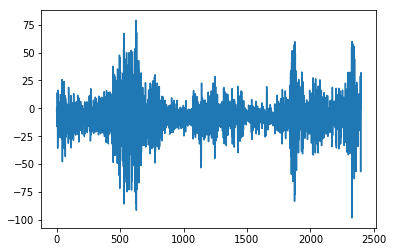

In [97]:
vs = f[0] #virtual source trace
plt.plot(vs.data)

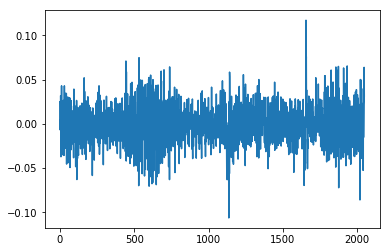

In [98]:
ret = spectralWhitening(vs.data)
vs.data = ret
plt.plot(ret)

In [99]:
shift = int(vs.stats.npts)

In [100]:
def whiten(trace):
    
    w_dat = spectralWhitening(trace.data)
    trace.data = w_dat
    
    return trace

In [101]:
f0 = whiten(f[0])
fc = correlate(f0,whiten(f[1]),shift)
X = np.linspace(-60,60,2*shift+1)

In [102]:
Xcorr_mat = np.zeros([len(fc),180])
Xcorr_mat[:,0] = fc

In [103]:
for i in range(1,180):
    fc = correlate(f0,whiten(f[i]),shift)
    Xcorr_mat[:,i] = fc

(-1, 1)

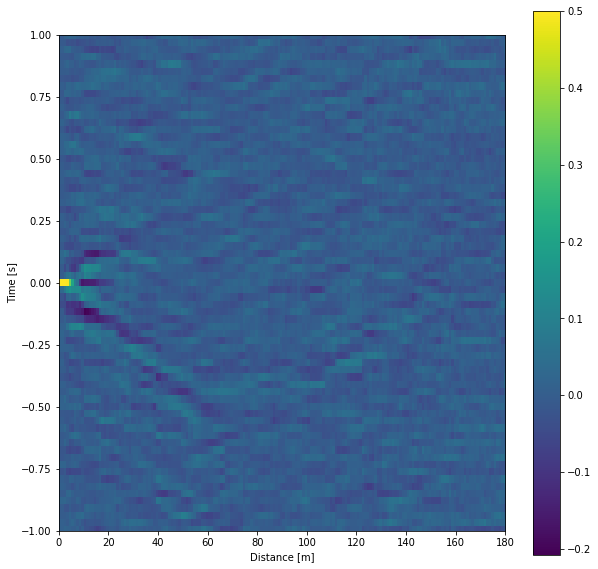

In [104]:
plt.figure(figsize=(10,10))
plt.imshow(Xcorr_mat,aspect=100,extent=[0,180,-60,60],vmax=0.5,interpolation='nearest')
plt.colorbar()
plt.xlabel('Distance [m]')
plt.ylabel('Time [s]')
plt.ylim([-1,1])

In [133]:
### Lets do a simple stack of the data

fcount = 0
for infile in list(fnames[1000:1060]):
    print(infile)
    
    f = op.read(infile,format='mseed')
    f.detrend('demean')
    f.detrend('linear')
    
    trace = despike(f[0],100)
    
    if not np.isnan(trace.data).any():
        
        try:
        
           shift = trace.stats.npts
        
           if fcount == 0:
            
               f0 = whiten(trace)
               f1 = whiten(despike(f[1],100))
               fc = correlate(f0,f1,shift)
               X = np.linspace(-60,60,2*shift+1) #length of Xcorr in time
            
               Xcorr_mat = np.zeros([len(fc),180])
               Xcorr_mat[:,0] = fc
            
               for i in range(1,180):
                   fi = despike(whiten(f[i]))
                   fc = correlate(f0,fi,shift)
                   Xcorr_mat[:,i] = fc
        
           else:
            
               f0 = whiten(f[0])
               fc = correlate(f0,whiten(f[1]),shift)
            
               for i in range(1,180):
                   fc = correlate(f0,whiten(f[i]),shift)
                   Xcorr_mat[:,i] += fc
                                      
           fcount += 1
        
        except:
            
            print("Issue in cross correlating file %s" %infile)
    
    else:
        
        print("Spike detected in %s: moving on" %infile)

Xcorr_mat = Xcorr_mat/fcount

./20160806145723_40_Hz_LineCSN.mseed
./20160806145823_40_Hz_LineCSN.mseed
./20160806145923_40_Hz_LineCSN.mseed
./20160806150023_40_Hz_LineCSN.mseed
./20160806150123_40_Hz_LineCSN.mseed
./20160806150223_40_Hz_LineCSN.mseed
./20160806150323_40_Hz_LineCSN.mseed
./20160806150423_40_Hz_LineCSN.mseed
./20160806150523_40_Hz_LineCSN.mseed
./20160806150623_40_Hz_LineCSN.mseed
./20160806150723_40_Hz_LineCSN.mseed
./20160806150823_40_Hz_LineCSN.mseed
./20160806150923_40_Hz_LineCSN.mseed
./20160806151023_40_Hz_LineCSN.mseed
./20160806151123_40_Hz_LineCSN.mseed
./20160806151223_40_Hz_LineCSN.mseed
./20160806151323_40_Hz_LineCSN.mseed
./20160806151423_40_Hz_LineCSN.mseed
./20160806151523_40_Hz_LineCSN.mseed
./20160806151623_40_Hz_LineCSN.mseed
./20160806151723_40_Hz_LineCSN.mseed
./20160806151823_40_Hz_LineCSN.mseed
./20160806151923_40_Hz_LineCSN.mseed
./20160806152023_40_Hz_LineCSN.mseed
./20160806152123_40_Hz_LineCSN.mseed
./20160806152223_40_Hz_LineCSN.mseed
./20160806152323_40_Hz_LineCSN.mseed
.

(-0.5, 0.5)

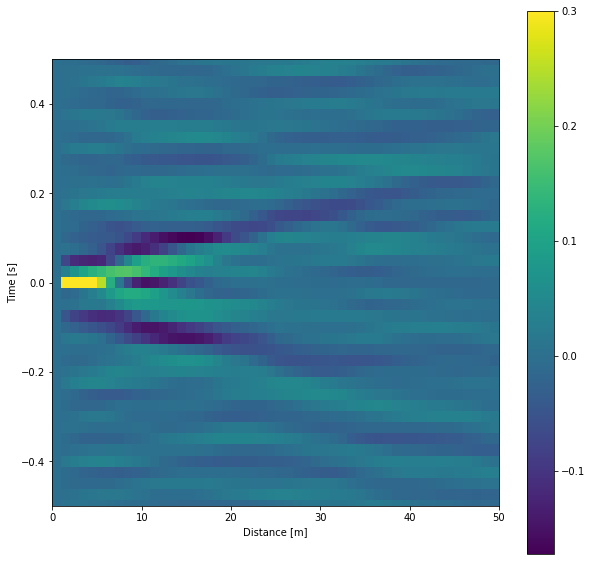

In [132]:
plt.figure(figsize=(10,10))
plt.imshow(Xcorr_mat,aspect=50,extent=[0,180,-60,60],vmax=0.3)
plt.colorbar()
plt.xlabel('Distance [m]')
plt.ylabel('Time [s]')
plt.xlim([0,50])
plt.ylim([-0.5,0.5])

(-1, 1)

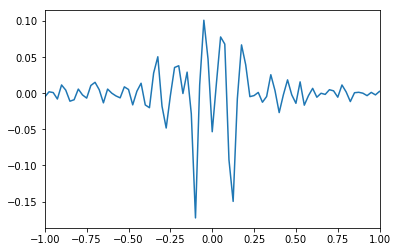

In [127]:
plt.plot(X,Xcorr_mat[:,15])
plt.xlim([-1,1])